# Programming Assignment #3: Convolutional Networks

## Collecting a Dataset

You will collect a dataset from Kaggle (https://www.kaggle.com/alxmamaev/flowers-recognition ).

In [1]:
import os
import random
import shutil
from tqdm import tqdm
# To create the same dataset
random.seed(0)

In [25]:
# making sure that we use GPU
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
# replace it with your directory path
base = '/home/nabil/Bureau/3A/courses/machine_learning/lab/lab_2020/Applied-Machine-Learning/CNN'

In [3]:
original_dataset_dir = os.path.join(base, 'flowers')
dataset = os.path.join(base, 'flowers_split')

train_dir = os.path.join(dataset, 'train')
validation_dir = os.path.join(dataset, 'validation')
test_dir = os.path.join(dataset, 'test')

categories = os.listdir(original_dataset_dir)
categories = [category for category in categories if not category.startswith('.')]
print('Image types:', categories)
data_folders = [os.path.join(original_dataset_dir, category) for category in categories]

Image types: ['dandelion', 'daisy', 'tulip', 'sunflower', 'rose']


We build the (image, label) pairs

In [4]:
pairs = []
for folder, category in zip(data_folders, categories):
    images = os.listdir(folder)
    images = [image for image in images if not image.startswith('.')]
    pairs.extend([(image, category) for image in images])

We define a split. We will run this part only once to create the partition into training, validation, and test sets.

In [5]:
if not os.path.isdir(dataset):
    random.shuffle(pairs)
    img_nbr = len(pairs)
    train_images = pairs[0:int(0.6 * img_nbr)]
    val_images = pairs[int(0.6 * img_nbr):int(0.8 * img_nbr)]
    test_images = pairs[int(0.8 * img_nbr):]

We create the three subsets. We will run this part only once to create the partition into training, validation, and test sets.

In [6]:
if not os.path.isdir(dataset):
    for image, label in tqdm(train_images):
        src = os.path.join(original_dataset_dir, label, image)
        dst = os.path.join(train_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copyfile(src, dst)

    for image, label in tqdm(val_images):
        src = os.path.join(original_dataset_dir, label, image)
        dst = os.path.join(validation_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copyfile(src, dst)

    for image, label in tqdm(test_images):
        src = os.path.join(original_dataset_dir, label, image)
        dst = os.path.join(test_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copyfile(src, dst)

In [7]:
# The target shape
dimension = (150, 150)
dimensions = (150, 150, 3)

## Building a Simple Convolutional Neural Network

### Architecture

Create a simple convolutional network and train a model with the train set. You can start from the architecture proposed by Chollet, Listing 5.5 (in Chollet's notebook 5.2), and a small number of epochs. Use the `ImageDataGenerator` class to scale your images as in the book:
```
train_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)
```
* You will need to modify some parameters so that your network handles multiple classes.
* You will also adjust the number of steps so that your generator in the fitting procedure sees all the samples.
* You will report the training and validation losses and accuracies and comment on the possible overfit.

In [8]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
EPOCHS = 30
OPTIMIZER = 'rmsprop'
# The pretrained network
PRETRAINED = 'INCEPTION'

In [9]:
# Data preprocessing
train_path = os.path.join(dataset, 'train')
test_path = os.path.join(dataset, 'test')
val_path = os.path.join(dataset, 'validation')

Create the network and compile it

In [10]:
classifier = models.Sequential()
classifier.add(layers.Conv2D(filters = 32, kernel_size = 3, input_shape = dimensions))
classifier.add(layers.MaxPooling2D(pool_size = (2, 2)))
classifier.add(layers.Conv2D(filters = 64, kernel_size = 3 , activation='relu'))
classifier.add(layers.MaxPooling2D(pool_size = (2, 2)))
classifier.add(layers.Conv2D(filters = 128, kernel_size = 3, activation='relu'))
classifier.add(layers.MaxPooling2D(pool_size = (2, 2)))
classifier.add(layers.Conv2D(filters = 128, kernel_size = 3, activation='relu'))
classifier.add(layers.MaxPooling2D(pool_size = (2, 2)))
classifier.add(layers.Flatten())
classifier.add(layers.Dense(units = 512, activation='relu'))
classifier.add(layers.Dense(units = 5, activation='softmax'))
classifier.compile(optimizer = OPTIMIZER,
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy'])

Create now the data generators for the training, validation, and test set

In [11]:
# normalizing and scaling data
train_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
        train_path, target_size = dimension,
        batch_size = 20,
        class_mode="categorical")

val_generator = val_datagen.flow_from_directory(
        val_path, target_size = dimension,
        batch_size = 20,
        class_mode="categorical")

test_generator = test_datagen.flow_from_directory(
        test_path, target_size = dimension,
        batch_size = 20,
        shuffle=False,
        class_mode="categorical")


Found 2595 images belonging to 5 classes.
Found 863 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


Compute `STEPS_PER_EPOCH` and `VALIDATION_STEPS`

In [12]:
STEPS_PER_EPOCH = train_generator.n // train_generator.batch_size
VALIDATION_STEPS = val_generator.n // val_generator.batch_size

And fit your model

In [13]:
history = classifier.fit_generator(train_generator, steps_per_epoch=STEPS_PER_EPOCH,
                                   epochs = EPOCHS,
                                   validation_data = val_generator,
                                   validation_steps = VALIDATION_STEPS)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
129/129 [==============================] - 10s 81ms/step - loss: 1.4440 - accuracy: 0.4043 - val_loss: 1.1818 - val_accuracy: 0.4686
Epoch 2/30
129/129 [==============================] - 7s 52ms/step - loss: 1.0892 - accuracy: 0.5588 - val_loss: 0.9525 - val_accuracy: 0.6349
Epoch 3/30
129/129 [==============================] - 7s 52ms/step - loss: 0.9248 - accuracy: 0.6365 - val_loss: 0.9141 - val_accuracy: 0.6314
Epoch 4/30
129/129 [==============================] - 7s 52ms/step - loss: 0.7884 - accuracy: 0.7111 - val_loss: 0.9135 - val_accuracy: 0.6523
Epoch 5/30
129/129 [==============================] - 7s 52ms/step - loss: 0.6965 - accuracy: 0.7511 - val_loss: 0.8429 - val_accuracy: 0.6779
Epoch 6/30
129/129 [==============================] - 7s 52ms/step - loss: 0.5359 - accuracy: 0.7988 - val_loss: 1.0240 - val_accuracy: 0.6721
Epoch 7/30
129/129 [==============================] - 7s 52ms/ste

In [14]:
# save the model
classifier.save('classifier_1.h5')

In [15]:
classifier = load_model('classifier_2.h5')

In [16]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

### Analyzing the fitting performance over epochs

As in Chollet's examples, print the training and validation loss

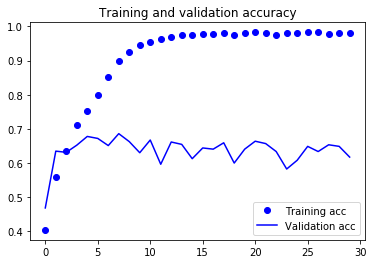

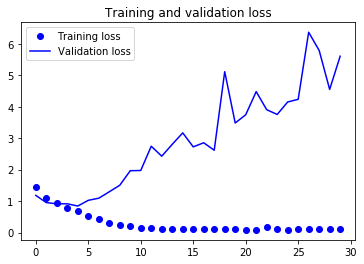

In [17]:
def plot_perf():
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
plot_perf()

### Predicting the test set

Apply now your network to the test set

In [19]:
# predict
y_hat = classifier.predict_generator(test_generator, test_generator.n//test_generator.batch_size +1)
y_hat = np.argmax(y_hat, axis=1)

# true labels
y_true = test_generator.classes

Report the accuracy as well as the classification report. Use sklearn functions

In [20]:
print('Simple CNN')
print("Class indices ", train_generator.class_indices)
print("sklearn accuracy:", accuracy_score(y_true, y_hat))
print("Classification report:\n",classification_report(y_true, y_hat))

Simple CNN
Class indices  {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}
sklearn accuracy: 0.6358381502890174
Classification report:
               precision    recall  f1-score   support

           0       0.65      0.56      0.60       162
           1       0.71      0.75      0.72       228
           2       0.55      0.44      0.49       152
           3       0.61      0.74      0.67       137
           4       0.61      0.66      0.63       186

    accuracy                           0.64       865
   macro avg       0.63      0.63      0.62       865
weighted avg       0.63      0.64      0.63       865



Print the confusion matrix

In [21]:
# the confusion matrix
print(confusion_matrix(y_true, y_hat))

[[ 90  26  12  22  12]
 [ 20 170   7  24   7]
 [ 13  12  67   9  51]
 [  6  19   4 101   7]
 [  9  14  32   9 122]]


Finally, run a model evaluation and store the loss and accuracy in the `test_loss_1` and `test_acc_1` variables. As with fitting, you may need to adjust the number of steps so that your network tests all the samples.

In [22]:
test_loss_1, test_acc_1 = classifier.evaluate_generator(test_generator, test_generator.n//test_generator.batch_size +1)
test_loss_1, test_acc_1

(13.753254890441895, 0.6358381509780884)

### Optimizing our model:

In [19]:
# Classifier
def classifier():
    classifier = models.Sequential()

    classifier.add(layers.Conv2D(filters = 32, kernel_size = 5, input_shape = dimensions))
    classifier.add(layers.MaxPooling2D(pool_size = (2, 2)))
    classifier.add(layers.BatchNormalization())
    classifier.add(layers.Dropout(0.2))

    classifier.add(layers.Conv2D(filters = 64, kernel_size = 3 , activation='relu'))
    classifier.add(layers.MaxPooling2D(pool_size = (2, 2)))
    classifier.add(layers.BatchNormalization())
    classifier.add(layers.Dropout(0.2))

    classifier.add(layers.Conv2D(filters = 96, kernel_size = 3 , activation='relu'))
    classifier.add(layers.MaxPooling2D(pool_size = (2, 2)))
    classifier.add(layers.BatchNormalization())
    classifier.add(layers.Dropout(0.2))

    classifier.add(layers.Conv2D(filters = 128, kernel_size = 3 , activation='relu'))
    classifier.add(layers.MaxPooling2D(pool_size = (2, 2)))
    classifier.add(layers.BatchNormalization())
    classifier.add(layers.Dropout(0.3))
    
    classifier.add(layers.Conv2D(filters = 256, kernel_size = 3 , activation='relu'))
    classifier.add(layers.MaxPooling2D(pool_size = (2, 2)))
    classifier.add(layers.BatchNormalization())
    classifier.add(layers.Dropout(0.3))

    classifier.add(layers.Flatten())

    classifier.add(layers.Dense(units = 256, activation='relu', input_dim= 5*7*128 ))
    classifier.add(layers.Dropout(0.3))
    classifier.add(layers.BatchNormalization())
    # classifier.add(layers.BatchNormalization())

    classifier.add(layers.Dense(units = 5, activation='softmax'))

    classifier.compile(optimizer = OPTIMIZER, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return classifier

In [20]:
classifier1 = classifier()
classifier1.summary()
history = classifier1.fit_generator(train_generator, steps_per_epoch=STEPS_PER_EPOCH,
                                   epochs = EPOCHS,
                                   validation_data = val_generator,
                                   validation_steps = VALIDATION_STEPS)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 146, 146, 32)      2432      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 73, 73, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 35, 35, 64)       

In [26]:
# save the model
classifier1.save('classifier_2.h5')

In [27]:
classifier1 = load_model('classifier_2.h5')

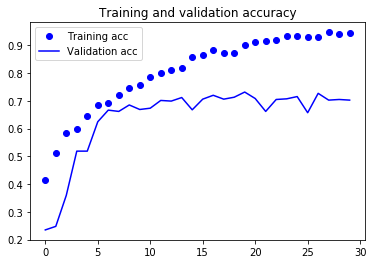

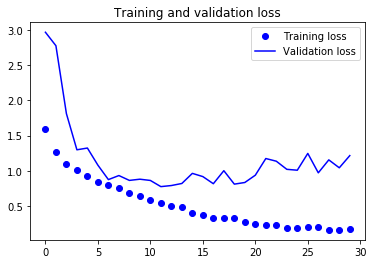

In [28]:
plot_perf()

In [29]:
# predict
y_hat = classifier1.predict_generator(test_generator, test_generator.n//test_generator.batch_size +1)
y_hat = np.argmax(y_hat, axis=1)

# true labelslab
y_true = test_generator.classes

Instructions for updating:
Please use Model.predict, which supports generators.


In [30]:
print('Simple CNN')
print("Class indices ", train_generator.class_indices)
print("sklearn accuracy:", accuracy_score(y_true, y_hat))
print("Classification report:\n",classification_report(y_true, y_hat))
print(confusion_matrix(y_true, y_hat))

Simple CNN
Class indices  {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}
sklearn accuracy: 0.7132947976878613
Classification report:
               precision    recall  f1-score   support

           0       0.95      0.53      0.68       162
           1       0.69      0.86      0.77       228
           2       0.78      0.49      0.60       152
           3       0.70      0.86      0.77       137
           4       0.63      0.77      0.69       186

    accuracy                           0.71       865
   macro avg       0.75      0.70      0.70       865
weighted avg       0.74      0.71      0.71       865

[[ 86  34   6  18  18]
 [  2 195   1  23   7]
 [  1  22  74   3  52]
 [  1   9   1 118   8]
 [  1  21  13   7 144]]


In [31]:
test_loss_1, test_acc_1 = classifier1.evaluate_generator(test_generator, test_generator.n//test_generator.batch_size +1)
test_loss_1, test_acc_1

Instructions for updating:
Please use Model.evaluate, which supports generators.


(1.1903374195098877, 0.7132948040962219)

Try to improve your model by modifying some parameters and evaluate your network again.

## Using Image Augmentation

### Architecture

The flower dataset is relatively small. A way to expand such datasets is to generate artificial images by applying small transformations to existing images. Keras provides a built-in class for this: `ImageDataGenerator`. You will reuse it and apply it to the flower data set.
1. Using the network from the previous exercise, apply some transformations to your images. You can start from Chollet, Listing 5.11 (in notebook 5.2 also).
2. Report the training and validation losses and accuracies and comment on the possible overfit.
3. Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.


Write a new generator for the training set

In [33]:
train_datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        train_path, target_size = dimension,
        batch_size = 20,
        class_mode="categorical")

val_generator = val_datagen.flow_from_directory(
        val_path, target_size = dimension,
        batch_size = 20,
        class_mode="categorical")

test_generator = test_datagen.flow_from_directory(
        test_path, target_size = dimension,
        batch_size = 20,
        shuffle=False,
        class_mode="categorical")

Found 2595 images belonging to 5 classes.
Found 863 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


Fit a model. You reset the model by recreating it.

In [34]:
STEPS_PER_EPOCH = train_generator.n // train_generator.batch_size
VALIDATION_STEPS = val_generator.n // val_generator.batch_size
classifier2 = classifier()
history = classifier2.fit_generator(train_generator, steps_per_epoch=STEPS_PER_EPOCH,
                                   epochs = EPOCHS,
                                   validation_data = val_generator,
                                   validation_steps = VALIDATION_STEPS)

Epoch 1/30
129/129 [==============================] - 15s 119ms/step - loss: 1.6904 - accuracy: 0.3650 - val_loss: 2.3535 - val_accuracy: 0.2593
Epoch 2/30
129/129 [==============================] - 15s 118ms/step - loss: 1.3460 - accuracy: 0.4629 - val_loss: 1.9657 - val_accuracy: 0.3663
Epoch 3/30
129/129 [==============================] - 15s 119ms/step - loss: 1.2634 - accuracy: 0.5021 - val_loss: 1.3821 - val_accuracy: 0.4616
Epoch 4/30
129/129 [==============================] - 15s 118ms/step - loss: 1.1906 - accuracy: 0.5270 - val_loss: 1.0317 - val_accuracy: 0.5733
Epoch 5/30
129/129 [==============================] - 15s 118ms/step - loss: 1.1058 - accuracy: 0.5717 - val_loss: 1.3590 - val_accuracy: 0.5593
Epoch 6/30
129/129 [==============================] - 15s 119ms/step - loss: 1.0556 - accuracy: 0.5930 - val_loss: 1.2788 - val_accuracy: 0.5651
Epoch 7/30
129/129 [==============================] - 15s 119ms/step - loss: 0.9970 - accuracy: 0.6214 - val_loss: 1.3672 - val_ac

In [35]:
# save the model
classifier2.save('classifier_aug.h5')

In [36]:
classifier2 = load_model('classifier_aug.h5')

### Analyzing the fitting performance over epochs

Show the training accuracy along with the epochs

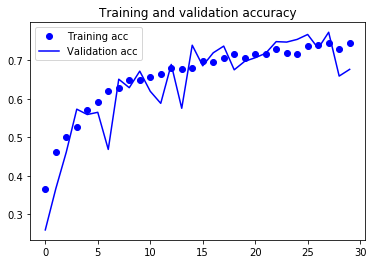

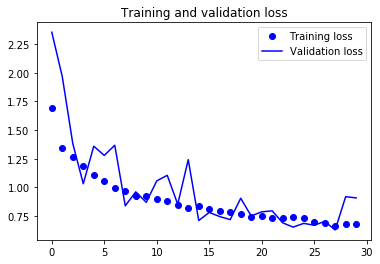

In [37]:
plot_perf()

### Predicting the test set

Finally, run a model evaluation and store the loss and accuracy in the `test_loss_2` and `test_acc_2` variables.

In [38]:
# predict
y_hat = classifier2.predict_generator(test_generator, test_generator.n//test_generator.batch_size +1)
y_hat = np.argmax(y_hat, axis=1)
# true labels
y_true = test_generator.classes
print("sklearn accuracy:", accuracy_score(y_true, y_hat))
print("Classification report:\n",classification_report(y_true, y_hat))
print("Confusion matrix:\n", confusion_matrix(y_true, y_hat))

sklearn accuracy: 0.6728323699421965
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.48      0.62       162
           1       0.83      0.68      0.75       228
           2       0.93      0.43      0.59       152
           3       0.46      0.95      0.62       137
           4       0.65      0.84      0.73       186

    accuracy                           0.67       865
   macro avg       0.75      0.67      0.66       865
weighted avg       0.76      0.67      0.67       865

Confusion matrix:
 [[ 77  16   0  58  11]
 [  1 154   0  58  15]
 [  1   9  65  22  55]
 [  2   0   1 130   4]
 [  4   6   4  16 156]]


In [39]:
test_loss_2, test_acc_2 = classifier2.evaluate_generator(test_generator, test_generator.n//test_generator.batch_size +1)
test_loss_2, test_acc_2

(0.9700126051902771, 0.6728323698043823)

## Using a Pretrained Convolutional Base

### Architecture

Some research teams have trained convolutional neural networks on much larger datasets. We have seen during the lecture that the networks can model conceptual patterns as they go through the layers. This was identified by Le Cun in his first experiments [http://yann.lecun.com/exdb/lenet/](http://yann.lecun.com/exdb/lenet/). In this last part, you will train classifiers on top of a pretrained convolutional base.
1. Train your network and report the training and validation losses and accuracies.
2. Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.

In [40]:
from keras.applications import VGG16, InceptionV3

In [41]:
if PRETRAINED == 'VGG':
    conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
else:
    conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 150, 3))
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 74, 74, 32)   96          conv2d_14[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization_12[0][0]     
_______________________________________________________________________________________

As in Chollet, Listing 5.17 (in Chollet's notebook 5.3), you will program an `extract_features()` function.

In [54]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20
def extract_features(directory, sample_count):
    shuffle = False if directory == test_path else True
    features = np.zeros(shape=(sample_count, 3, 3, 2048))
    labels = np.zeros(shape=(sample_count, 5))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size=batch_size,
        shuffle= shuffle,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

The features and labels

In [55]:
train_features, train_labels = extract_features(train_path, 2595)
validation_features, validation_labels = extract_features(val_path, 863)
test_features, test_labels = extract_features(test_path, 865)

Found 2595 images belonging to 5 classes.
Found 863 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


In [56]:
train_features = np.reshape(train_features, (train_features.shape[0], np.prod(train_features.shape[1:])))  # (2593, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (validation_features.shape[0], np.prod(validation_features.shape[1:]))) # (865, 4 * 4 * 512)
test_features = np.reshape(test_features, (test_features.shape[0], np.prod(test_features.shape[1:]))) # (865, 4 * 4 * 512))

Build a network that consists of the Inception V3 convolutional base and two dense layers.

In [57]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim= np.prod(test_features.shape[1:])))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(5, activation='softmax'))

model.compile(optimizer=OPTIMIZER,
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 1285      
Total params: 4,720,133
Trainable params: 4,720,133
Non-trainable params: 0
_________________________________________________________________


Fit your network

In [58]:

history = model.fit(train_features, train_labels,
                    batch_size = batch_size,
                    epochs=30,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
130/130 [==============================] - 1s 6ms/step - loss: 4.3839 - accuracy: 0.2578 - val_loss: 3.4309 - val_accuracy: 0.3581
Epoch 2/30
130/130 [==============================] - 1s 6ms/step - loss: 3.4734 - accuracy: 0.3846 - val_loss: 2.8540 - val_accuracy: 0.4832
Epoch 3/30
130/130 [==============================] - 1s 6ms/step - loss: 2.8191 - accuracy: 0.4825 - val_loss: 2.6730 - val_accuracy: 0.4844
Epoch 4/30
130/130 [==============================] - 1s 6ms/step - loss: 2.1009 - accuracy: 0.5911 - val_loss: 1.9103 - val_accuracy: 0.6315
Epoch 5/30
130/130 [==============================] - 1s 6ms/step - loss: 1.7502 - accuracy: 0.6435 - val_loss: 1.8492 - val_accuracy: 0.6083
Epoch 6/30
130/130 [==============================] - 1s 6ms/step - loss: 1.1971 - accuracy: 0.6555 - val_loss: 0.3120 - val_accuracy: 0.7103
Epoch 7/30
130/130 [==============================] - 1s 6ms/step - loss: 0.3193 - accuracy: 0.7256 - val_loss: 0.2394 - val_accuracy: 0.7601
Epoch 

### Analyzing the fitting performance over epochs

Show the training accuracy along with the epochs

In [65]:
# save the model
model.save('classifier_pre.h5')

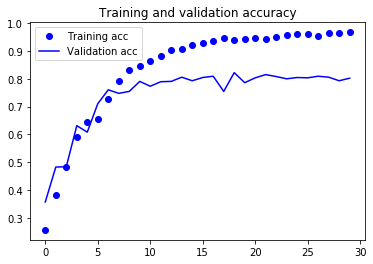

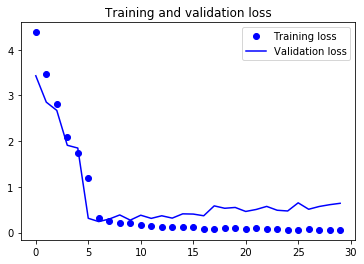

In [66]:
model = load_model('classifier_pre.h5')
plot_perf()

### Predicting the test set

Apply now your network to the test set

In [67]:
test_hat = list(model.predict_classes(test_features))

test_labels_1 = list(np.argmax(test_labels, axis=1))

Report the accuracy as well as the classification report. Use sklearn functions

In [68]:
print('Simple CNN')
print("sklearn accuracy:", accuracy_score(test_labels_1, test_hat))
print("Classification report:\n",classification_report(test_labels_1, test_hat))

Simple CNN
sklearn accuracy: 0.815028901734104
Classification report:
               precision    recall  f1-score   support

           0       0.82      0.80      0.81       162
           1       0.83      0.88      0.86       228
           2       0.80      0.72      0.76       152
           3       0.92      0.75      0.83       137
           4       0.75      0.87      0.80       186

    accuracy                           0.82       865
   macro avg       0.82      0.81      0.81       865
weighted avg       0.82      0.82      0.81       865



Print the confusion matrix

In [69]:
print("Confusion matrix:\n", confusion_matrix(test_labels_1, test_hat))

Confusion matrix:
 [[130  17   5   2   8]
 [ 12 201   4   4   7]
 [  7   4 110   2  29]
 [  5  13   5 103  11]
 [  4   6  14   1 161]]


Finally, run a model evaluation and store the loss and accuracy in the `test_loss_3` and `test_acc_3` variables. As with fitting, you may need to adjust the number of steps so that your network tests all the samples.

In [70]:
test_loss_3, test_acc_3 = model.evaluate(test_features,test_labels)
test_loss_3, test_acc_3

28/28 [==============================] - 0s 2ms/step - loss: 0.5586 - accuracy: 0.8150


(0.5586255788803101, 0.8150289058685303)

## Using a Pretrained Convolutional Base with Image Augmentation

### Architecture

1. Modify your program to include an image transformer. Train a new model. As a hint, you can make the whole convolutional base trainable and use the stochastic gradient descent as optimizer.
2. Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.

In [71]:
if PRETRAINED == 'VGG':
    conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
else:
    conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 150, 3))
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_108 (Conv2D)             (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_106 (BatchN (None, 74, 74, 32)   96          conv2d_108[0][0]                 
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_106[0][0]    
_______________________________________________________________________________________

In [72]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', input_dim= 3*3*2048 ))
model.add(layers.BatchNormalization())

model.add(layers.Dense(5, activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_3 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               4718848   
_________________________________________________________________
batch_normalization_200 (Bat (None, 256)               1024      
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 1285      
Total params: 26,523,941
Trainable params: 26,488,997
Non-trainable params: 34,944
_________________________________________________________________


Create the generators

In [76]:
batch = 20
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=10,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.1,
      horizontal_flip=True,
      vertical_flip=False)

train_generator = train_datagen.flow_from_directory(
        train_path, target_size = dimension,
        batch_size = batch,
        class_mode="categorical")

val_generator = val_datagen.flow_from_directory(
        val_path, target_size = dimension,
        batch_size =batch,
        class_mode="categorical")

test_generator = test_datagen.flow_from_directory(
        test_path, target_size = dimension,
        batch_size = batch,
        shuffle=False,
        class_mode="categorical")

Found 2595 images belonging to 5 classes.
Found 863 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


In [77]:
model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Fit the model

In [78]:
STEPS_PER_EPOCH = train_generator.n // train_generator.batch_size
VALIDATION_STEPS = val_generator.n // val_generator.batch_size
history = model.fit_generator(train_generator, steps_per_epoch=STEPS_PER_EPOCH,
                                   epochs = EPOCHS,
                                   validation_data = val_generator,
                                   validation_steps = VALIDATION_STEPS)


Epoch 1/30
129/129 [==============================] - 49s 376ms/step - loss: 0.1729 - accuracy: 0.8206 - val_loss: 0.1945 - val_accuracy: 0.8116
Epoch 2/30
129/129 [==============================] - 18s 137ms/step - loss: 0.1562 - accuracy: 0.8416 - val_loss: 0.1657 - val_accuracy: 0.8326
Epoch 3/30
129/129 [==============================] - 18s 139ms/step - loss: 0.1280 - accuracy: 0.8722 - val_loss: 0.1540 - val_accuracy: 0.8465
Epoch 4/30
129/129 [==============================] - 20s 156ms/step - loss: 0.1230 - accuracy: 0.8683 - val_loss: 0.1555 - val_accuracy: 0.8558
Epoch 5/30
129/129 [==============================] - 19s 151ms/step - loss: 0.1103 - accuracy: 0.8816 - val_loss: 0.1419 - val_accuracy: 0.8628
Epoch 6/30
129/129 [==============================] - 20s 158ms/step - loss: 0.1088 - accuracy: 0.8893 - val_loss: 0.1490 - val_accuracy: 0.8628
Epoch 7/30
129/129 [==============================] - 22s 173ms/step - loss: 0.1007 - accuracy: 0.8975 - val_loss: 0.1383 - val_ac

### Analyzing the fitting performance over epochs

Show the training accuracy along with the epochs

In [79]:
# save the model
model.save('classifier_pre_aug.h5')

In [80]:
model = load_model('classifier_pre_aug.h5')

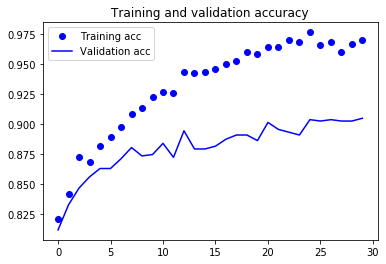

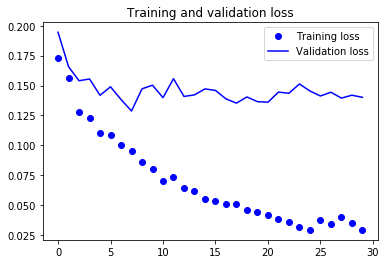

In [81]:
plot_perf()

### Predicting the test set

Apply now your network to the test set

In [87]:
# predict
y_hat = model.predict_generator(test_generator, steps=test_generator.n//test_generator.batch_size +1)
y_hat = y_hat.argmax(1)
# true labels
y_true = test_generator.classes


Report the accuracy as well as the classification report. Use sklearn functions

In [88]:
print("Class indices ", train_generator.class_indices)
print("sklearn accuracy:", accuracy_score(y_true, y_hat))
print("Classification report:\n",classification_report(y_true, y_hat, target_names=train_generator.class_indices.keys()))

Class indices  {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}
sklearn accuracy: 0.8797687861271676
Classification report:
               precision    recall  f1-score   support

       daisy       0.93      0.86      0.89       162
   dandelion       0.91      0.94      0.93       228
        rose       0.87      0.78      0.82       152
   sunflower       0.89      0.91      0.90       137
       tulip       0.81      0.88      0.84       186

    accuracy                           0.88       865
   macro avg       0.88      0.87      0.88       865
weighted avg       0.88      0.88      0.88       865



Print the confusion matrix

In [84]:
print("Classification report:\n", confusion_matrix(y_true, y_hat))

Classification report:
 [[140  10   4   4   4]
 [  5 215   1   2   5]
 [  0   3 118   3  28]
 [  2   5   4 124   2]
 [  4   3   9   6 164]]


Finally, run a model evaluation and store the loss and accuracy in the `test_loss_4` and `test_acc_4` variables. As with fitting, you may need to adjust the number of steps so that your network tests all the samples.

In [89]:
test_loss_4, test_acc_4 = model.evaluate_generator(test_generator, steps=test_generator.n//test_generator.batch_size +1)
test_loss_4, test_acc_4

(0.16645976901054382, 0.8797687888145447)

## Passing the Assignment

To pass the assignment, you need to reach an accuracy of 75 (even 80 ideally) with your best network.

In [90]:
(test_loss_1, test_acc_1), (test_loss_2, test_acc_2), (test_loss_3, test_acc_3), (test_loss_4, test_acc_4)

((1.1903374195098877, 0.7132948040962219),
 (0.9700126051902771, 0.6728323698043823),
 (0.5586255788803101, 0.8150289058685303),
 (0.16645976901054382, 0.8797687888145447))

In [91]:
import keras
import tensorflow as tf
keras.__version__

'2.4.3'

In [92]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K

## Visualizing heatmaps of class activation


In [93]:
from keras.applications.vgg16 import VGG16

K.clear_session()
model = VGG16(weights='imagenet')
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [94]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

# The local path to our target image
img_path = '/home/nabil/Bureau/3A/courses/machine_learning/lab/lab_2020/Applied-Machine-Learning/CNN/daisy.jpg'
img_path = '/home/nabil/Bureau/3A/courses/machine_learning/lab/lab_2020/Applied-Machine-Learning/CNN/lion.jpg'

# `img` is a PIL image of size 224x224
img = image.load_img(img_path, target_size=(224, 224))

# `x` is a float32 Numpy array of shape (224, 224, 3)
x = image.img_to_array(img)

# We add a dimension to transform our array into a "batch"
# of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)

# Finally we preprocess the batch
# (this does channel-wise color normalization)
x = preprocess_input(x)

In [95]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02129165', 'lion', 0.6496539), ('n02115913', 'dhole', 0.22982237), ('n02112137', 'chow', 0.028150598)]


To visualize which parts of our image were the most "African elephant"-like, let's set up the Grad-CAM process:

In [96]:
# This is the "african elephant" entry in the prediction vector
african_elephant_output = model.output[:, np.argmax(preds[0])]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model.get_layer('block5_conv3')

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `block5_conv3`,
# given a sample image
feature_extractor = tf.keras.models.Model(model.inputs, [last_conv_layer.output, model.output])

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
with tf.GradientTape() as tape:
    conv_layer_output_value, predictions = feature_extractor(x)
    loss = predictions[:, np.argmax(preds[0])]
grads = tape.gradient(loss, conv_layer_output_value)

pooled_grads = K.mean(grads, axis=(0, 1, 2))

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the elephant class
#for i in range(512):
#    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
conv_layer_output_value = tf.multiply(pooled_grads, conv_layer_output_value[0])

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

For visualization purpose, we will also normalize the heatmap between 0 and 1:

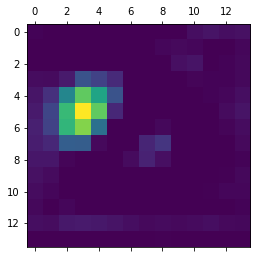

In [97]:
import matplotlib.pyplot as plt
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.savefig('heatmap_lion.png')
plt.show()

Finally, we will use OpenCV to generate an image that superimposes the original image with the heatmap we just obtained:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True

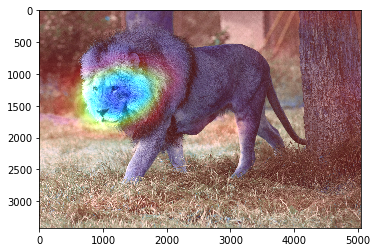

In [98]:
import cv2

# We use cv2 to load the original image
img = cv2.imread(img_path)/255.
plt.imshow(img)
# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)
plt.imshow(heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4/255. + img 
plt.imshow(superimposed_img)
# Save the image to disk
cv2.imwrite('heat_lion.jpg', superimposed_img)